<a href="https://colab.research.google.com/drive/1KSksZPsW6rNQfGW69wS8j5ietj3ayUkC" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notes :
- This notebook takes around 6 minutes to run.
- I underlined the differences between the exam in the following code like this: <font color="red">**CHANGE**</font>.

# 0 - Introduction

This section introduces the dataset loading process, utilizing the requests library to download the necessary data from the GitHub repository.

In [176]:
import requests

url = "https://github.com/PaRi29/DeepLearningExam/raw/main/assets/input_data.pkl"
response = requests.get(url)
with open("input_data.pkl", "wb") as f:
    f.write(response.content)

Download complete.


In [177]:
%pip install tensorflow

import warnings
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import string
import unicodedata
import nltk
from nltk.corpus import stopwords
import itertools
import keras


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, confusion_matrix

from keras.regularizers import l1, l2
from keras.layers import (
    Input, Dense, BatchNormalization, Dropout, Embedding,
    Bidirectional, LSTM, Concatenate
)
from keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences

warnings.filterwarnings("ignore")
np.random.seed(42)
tf.random.set_seed(42)

Note: you may need to restart the kernel to use updated packages.


I suppress warnings to keep the output clean; mainly related to known deprecations in libraries that do not impact the result.

sanity check, everything is working fine 

In [178]:
df = pd.read_pickle("input_data.pkl")
df.drop(columns=["Average_Score"],inplace=True) #Average_Score ws not part of the exam
df

,Hotel_Address,Review_Date,Hotel_Name,Reviewer_Nationality,Hotel_number_reviews,Reviewer_number_reviews,Review_Score,Review,Review_Type
88526,Scarsdale Scarsdale Place Kensington Kensingto...,5/2/2017,Copthorne Tara Hotel London Kensington,United Kingdom,7105,2,6.7,Expensive room rate that didn t include parki...,Bad_review
42019,53 53 59 Kilburn High Road Maida Vale London C...,8/4/2016,BEST WESTERN Maitrise Hotel Maida Vale,United Kingdom,1877,8,5.8,Bedroom in the basement No windows Very small...,Bad_review
80574,Pelai Pelai 28 Ciutat Vella 08002 Barcelona Spain,11/17/2016,Catalonia Ramblas 4 Sup,United Kingdom,4276,2,6.3,Room ready for a makeover Location,Bad_review
27131,3 3 Place du G n ral Koenig 17th arr 75017 Par...,2/4/2016,Hyatt Regency Paris Etoile,United Kingdom,3973,3,5.8,Firstly the lady at the check in desk was qui...,Bad_review
63857,Epping Epping Forest 30 Oak Hill London IG8 9N...,7/27/2016,Best Western PLUS Epping Forest,United Kingdom,587,7,3.3,Not being able to park my vehicle due to the ...,Bad_review
...,...,...,...,...,...,...,...,...,...
11403,150 150 Bayswater Road Kensington and Chelsea ...,3/9/2016,DoubleTree by Hilton London Hyde Park,Italy,2405,16,7.5,Cleanliness room temperature location Facilities,Good_review
18169,2 2 Rue Hector Malot 12th arr 75012 Paris France,9/1/2015,Novotel Paris Gare De Lyon,United Kingdom,3583,6,8.8,The cost of the parking The location,Good_review
15180,18 18 Albert Embankment Lambeth London SE1 7TJ UK,9/4/2016,Park Plaza London Riverbank,United Kingdom,4684,1,10.0,The staff was very helpful,Good_review
24929,26 26 Cadogan Gardens Kensington and Chelsea L...,10/6/2015,Draycott Hotel,Switzerland,245,9,10.0,Tout A home away from home,Good_review


To adhere to the practical time constraints of this evaluation, I have implemented a two-fold strategy to manage the overall computational cost while maintaining the methodological integrity of the project. This involves a trade-off between the volume of data processed and the breadth of hyperparameter exploration.

In [179]:
df_full = df.copy()

sample_fraction = 0.50
target_column = 'Review_Type'
reduced_df, _ = train_test_split(
    df_full,
    train_size=sample_fraction,
    stratify=df_full[target_column],
    random_state=42
)



---



# 2 - Input

This section in the exam was divided in two subparts:
* How to (if) preprocess input data and which data would you retain/use;
* Which is the input of the model, and how is it represented;

to avoid any kind of data leakage, I first divide into train, validation, and test

In [180]:
train_df, temp_df = train_test_split(
    reduced_df, test_size=0.20, random_state=42, shuffle=True
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=42, shuffle=True
)
print(len(train_df), len(val_df), len(test_df))

5508 689 689


## 2.1 preprocessing:

### 2.1.1 - Hotel_Name


In my exam solution, I stated that I would employ **one‑hot encoding** for the hotel name. I consider this feature important for the following reasons:
1. **Unique index**  
   One‑hot encoding transforms each hotel into a distinct binary vector that acts as a unique identifier.  
   - This allows the model to “recognize” and link reviews belonging to the same hotel, preserving continuity with previously seen reviews of that property.
2. **Preservation of hotel‑specific patterns**  
   By providing a sparse, binary representation, the model can learn hotel‑specific tendencies (for example, whether a given hotel generally receives more positive or negative feedback).
3. **Technical feasibility**  
   This approach remains practical **only if** the number of unique hotels stays within a manageable range. <font color="red">Small **CHANGE**</font> To control dimensionality, I group all hotels with fewer than a chosen cutoff of reviews (e.g., ≥ 20 or ≥ 25) into an “Other” category, limiting the total number of one-hot columns to a few hundred instead of thousands. After analyzing the impact of different cutoff thresholds on dimensionality, I chose min_review_cutoff = 20. This value represents a good compromise: it reduces the dimensions from over 1100 to a manageable ~31, while preserving the information on the most reviewed hotels that make up a significant part of the dataset. 

In [181]:
hotel_name_counts = train_df['Hotel_Name'].value_counts()
print(hotel_name_counts)

Hotel_Name
Britannia International Hotel Canary Wharf    107
Strand Palace Hotel                            53
Holiday Inn London Kensington                  46
Hilton London Metropole                        44
Park Plaza Westminster Bridge London           42
                                             ... 
Olivia Balmes Hotel                             1
Mercure Paris Bercy Biblioth que                1
St George Hotel                                 1
Upper Diagonal                                  1
La Villa Haussmann                              1
Name: count, Length: 1139, dtype: int64


In [182]:
for cutoff in [3, 5, 10, 20,25,30,35,40,45, 50]:
    n_slots = (hotel_name_counts >= cutoff).sum() + 1  
    print(f"min_reviews ≥{cutoff:2d} ==> {n_slots:3d} one-hot dimensions")


min_reviews ≥ 3 ==> 627 one-hot dimensions
min_reviews ≥ 5 ==> 367 one-hot dimensions
min_reviews ≥10 ==> 156 one-hot dimensions
min_reviews ≥20 ==>  31 one-hot dimensions
min_reviews ≥25 ==>  18 one-hot dimensions
min_reviews ≥30 ==>  12 one-hot dimensions
min_reviews ≥35 ==>   9 one-hot dimensions
min_reviews ≥40 ==>   6 one-hot dimensions
min_reviews ≥45 ==>   4 one-hot dimensions
min_reviews ≥50 ==>   3 one-hot dimensions


In [ ]:
hotel_counts_train = train_df['Hotel_Name'].value_counts()
min_review_cutoff = 20

frequent_hotels   = hotel_counts_train[hotel_counts_train >= min_review_cutoff].index

def encode_hotel(df, frequent_hotels):
    s = df['Hotel_Name'].where(df['Hotel_Name'].isin(frequent_hotels), 'Other')
    return pd.get_dummies(s, prefix='hotel')

train_hot = encode_hotel(train_df, frequent_hotels)
val_hot   = encode_hotel(val_df,   frequent_hotels)
test_hot  = encode_hotel(test_df,  frequent_hotels)
col_train = train_hot.columns
val_hot   = val_hot.reindex(columns=col_train, fill_value=0)
test_hot  = test_hot.reindex(columns=col_train, fill_value=0)


train_hot = train_hot.astype(np.float32)
val_hot = val_hot.astype(np.float32)
test_hot = test_hot.astype(np.float32)
print("Shape one‑hot:", train_hot.shape, val_hot.shape, test_hot.shape)

Shape one‑hot: (5508, 31) (689, 31) (689, 31)


### 2.1.2 - Hotel_Address


As stated in the exam, I decided to drop this information because I think it could not bring strong valuable insights 

In [184]:
cols_to_drop = ["Hotel_Address"]
train_df.drop(columns=cols_to_drop, inplace=True)
val_df.drop(columns=cols_to_drop, inplace=True)
test_df.drop(columns=cols_to_drop, inplace=True)


### 2.1.3 - Review Date

As stated in the exam, I am going to:

1. drop the day
2. convert the month using a cyclic sine/cosine function
3. convert the year, <font color="red">small **CHANGE**</font>: The conversion of the year into the number of years *since today* is partially incorrect because it makes the feature dependent on the training/deployment date, reducing model consistency. Instead, I convert the year into the number of years *since the earliest* review date in the dataset, ensuring stable and meaningful temporal representation.



In [185]:
def transform_dates(df, min_year=None):
    df['Review_Date'] = pd.to_datetime(df['Review_Date'], format='%m/%d/%Y')
    df['Review_Month'] = df['Review_Date'].dt.month
    df['Review_Year'] = df['Review_Date'].dt.year

    df['Review_Month_sin'] = np.sin(2 * np.pi * df['Review_Month'] / 12)
    df['Review_Month_cos'] = np.cos(2 * np.pi * df['Review_Month'] / 12)

    if min_year is None:
        min_year = df['Review_Year'].min()
    df['Review_Year_Since'] = df['Review_Year'] - min_year

    df.drop(columns=['Review_Date', 'Review_Month', 'Review_Year'], inplace=True)
    return df, min_year

train_df, min_year = transform_dates(train_df)
val_df, _ = transform_dates(val_df, min_year)
test_df, _ = transform_dates(test_df, min_year)

### 2.1.4 - Reviewer_Nationality

I chose to **exclude the "Reviewer Nationality"** feature due to concerns about **representation bias** and the risk of **spurious correlations**. While nationality might weakly correlate with review patterns, this is **not causally meaningful** and may reflect systemic imbalances — e.g., wealthier countries being overrepresented or visiting different types of hotels. Including it could lead the model to learn **stereotypical associations**, undermining fairness


In [186]:
cols_to_drop = ["Reviewer_Nationality"]
train_df.drop(columns=cols_to_drop, inplace=True)
val_df.drop(columns=cols_to_drop, inplace=True)
test_df.drop(columns=cols_to_drop, inplace=True)

### 2.1.5 Review text

I clean the review text by removing punctuation, stop words, and non-ASCII characters, and converting everything to lowercase

<font color="red">**CHANGE**</font> Using the term "Bag of Words" was imprecise. I didn't actually use the traditional BoW approach based on frequency vectors, but rather a structured representation feeding into an embedding layer. My intention was to express the idea of a structured input derived from the vocabulary. This terminological clarification does not modify the proposed architectural approach, but corrects the technical terminology for greater precision.

In [187]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def preprocess_review(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')    
    text = text.replace('--', ' ')    
    words = text.split()    
    table = str.maketrans('', '', string.punctuation)
    words = [w.translate(table) for w in words]    
    words = [w.lower() for w in words if w.isalpha() and w.lower() not in stop_words]
    return ' '.join(words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pablo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


To better understand the input data, I analyze the distribution of the number of words in each review after preprocessing. I compute basic statistics and plot a histogram to visualize how review lengths are spread. This helps verify whether the maximum length of 400 words is appropriate, or if a shorter cutoff would be sufficient for most reviews.

In [188]:
for df_ in [train_df, val_df, test_df]:
    df_["clean_text"] = df_["Review"].apply(preprocess_review)
    df_["review_length"] = df_["clean_text"].apply(lambda x: len(x.split()))
    df_["tokens"] = df_["clean_text"].str.split()

count    5508.000000
mean       14.057190
std        20.900679
min         0.000000
25%         3.000000
50%         6.000000
75%        17.000000
max       274.000000
Name: review_length, dtype: float64


Quantile 50%: Reviews have length <= 6 words.
Quantile 75%: Reviews have length <= 17 words.
Quantile 90%: Reviews have length <= 36 words.
Quantile 95%: Reviews have length <= 51 words.
Quantile 98%: Reviews have length <= 80 words.
Quantile 99%: Reviews have length <= 104 words.
Quantile 100%: Reviews have length <= 274 words.


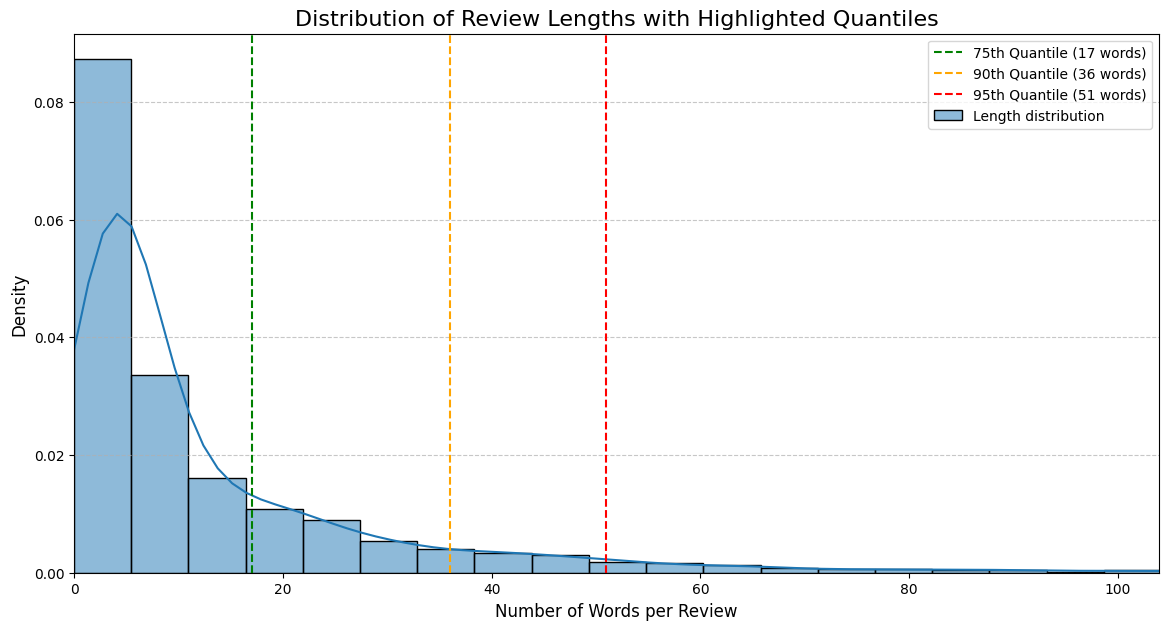

In [189]:
review_length_stats = train_df["review_length"].describe()
print(review_length_stats)
print("\n")

quantiles = [0.50, 0.75, 0.90, 0.95, 0.98, 0.99, 1.00]
for q in quantiles:
    length_at_quantile = train_df["review_length"].quantile(q)
    print(f"Quantile {q*100:.0f}%: Reviews have length <= {length_at_quantile:.0f} words.")

plt.figure(figsize=(14, 7))
sns.histplot(data=train_df, x="review_length", bins=50, kde=True,
             label="Length distribution", stat="density")
plt.axvline(train_df["review_length"].quantile(0.75), color='green', linestyle='--',
            label=f'75th Quantile ({train_df["review_length"].quantile(0.75):.0f} words)')
plt.axvline(train_df["review_length"].quantile(0.90), color='orange', linestyle='--',
            label=f'90th Quantile ({train_df["review_length"].quantile(0.90):.0f} words)')
plt.axvline(train_df["review_length"].quantile(0.95), color='red', linestyle='--',
            label=f'95th Quantile ({train_df["review_length"].quantile(0.95):.0f} words)')
plt.title('Distribution of Review Lengths with Highlighted Quantiles', fontsize=16)
plt.xlabel('Number of Words per Review', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.xlim(0, train_df["review_length"].quantile(0.99))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Based on the text preprocessing, a detailed analysis of the review lengths was conducted. The statistical summary and quantile distribution reveal several key insights:

*   The reviews are predominantly short, with a **mean length of 14 words** and a **median of only 6 words**.
*   The distribution is heavily skewed, as confirmed by the quantiles: **75% of reviews have 16 words or fewer**.
*   **95% of all reviews are shorter than 50 words**, and **99% are shorter than 102 words**. The absolute maximum length found in the dataset is 274 words.

<font color="red">**CHANGE**</font> In the exam, I said that without an analysis of the distribution of words (that I have just done above), I would have kept 400 as the upper bound. However, based on the review length distribution, where 75% of reviews have 16 words or fewer and the maximum length is 274 words, I decide to **truncate sequences at 100 words**. 

In [209]:
all_train_words = [word for tokens in train_df['tokens'] for word in tokens]
unique_words = sorted(list(set(all_train_words)))

word_index = {word: i + 2 for i, word in enumerate(unique_words)}
word_index["<OOV>"] = 1
MAX_LEN = 100
VOCAB_SIZE = len(unique_words) + 2


def text_to_sequence(tokens, word_index_dict):
    seq = [word_index_dict.get(word, word_index_dict["<OOV>"]) for word in tokens]
    return seq

train_sequences = [text_to_sequence(tokens, word_index) for tokens in train_df['tokens']]
val_sequences = [text_to_sequence(tokens, word_index) for tokens in val_df['tokens']]
test_sequences = [text_to_sequence(tokens, word_index) for tokens in test_df['tokens']]

train_seqs = pad_sequences(train_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
val_seqs = pad_sequences(val_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
test_seqs = pad_sequences(test_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

print("Shape of final training sequences tensor:", train_seqs.shape)
print("Example of a processed sequence:", train_seqs[27])

Shape of final training sequences tensor: (5508, 100)
Example of a processed sequence: [ 782 1100 2816 3872    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


### 2.1.6 - Hotel number reviews/Reviewer number reviews, 

In [191]:
scaler = MinMaxScaler()
numeric_cols = ['Hotel_number_reviews', 'Reviewer_number_reviews', 'Review_Year_Since', 
                'Review_Month_sin', 'Review_Month_cos']

train_nums = scaler.fit_transform(train_df[numeric_cols])
val_nums   = scaler.transform(val_df[numeric_cols])
test_nums  = scaler.transform(test_df[numeric_cols])




---



## 2.1. Input of the model 

The model architecture is designed to accept three distinct and parallel inputs, each representing a different type of information extracted from the original data. This multi-input architecture allows the model to learn specific representations for each data type before merging them for the final prediction.

The three input tensors are summarized below, showing the shape and a brief description of their content. These tensors represent the textual, categorical (hotel), and numerical data, respectively.

As outlined in the exam, the textual data input will be processed by the Bidirectional LSTM layer. The other two inputs (categorical and numerical), which are here separated just for clarity, will be concatenated with the output representation from the Bi-LSTM. This combined vector will then serve as the input for the subsequent fully-connected deep neural network.

In [192]:

print("\n1. TEXTUAL INPUT (Padded Token Sequences)")
print(f"   - Training tensor shape: {train_seqs.shape}")
print(f"   - Validation tensor shape: {val_seqs.shape}")
print(f"   - Test tensor shape: {test_seqs.shape}")

print("\n2. CATEGORICAL INPUT (One-Hot Encoded Hotels)")
print(f"   - Training tensor shape: {train_hot.shape}")
print(f"   - Validation tensor shape: {val_hot.shape}")
print(f"   - Test tensor shape: {test_hot.shape}")

print("\n3. NUMERICAL INPUT (Normalized Features)")
print(f"   - Training tensor shape: {train_nums.shape}")
print(f"   - Validation tensor shape: {val_nums.shape}")
print(f"   - Test tensor shape: {test_nums.shape}")
print(f"   - Included columns: {numeric_cols}")



1. TEXTUAL INPUT (Padded Token Sequences)
   - Training tensor shape: (5508, 100)
   - Validation tensor shape: (689, 100)
   - Test tensor shape: (689, 100)

2. CATEGORICAL INPUT (One-Hot Encoded Hotels)
   - Training tensor shape: (5508, 31)
   - Validation tensor shape: (689, 31)
   - Test tensor shape: (689, 31)

3. NUMERICAL INPUT (Normalized Features)
   - Training tensor shape: (5508, 5)
   - Validation tensor shape: (689, 5)
   - Test tensor shape: (689, 5)
   - Included columns: ['Hotel_number_reviews', 'Reviewer_number_reviews', 'Review_Year_Since', 'Review_Month_sin', 'Review_Month_cos']


# 3 - 4 - 5 OUTPUT - LOSS - MODEL CONFIGURATION

This section represents the following three parts:

3. OUTPUT: How would you design the output layer and why;
4. LOSS: Which loss function would you use to train your model and
why;
5. MODEL CONFIGURATION

  * Model composition: composition of layers, regardless their number,
  or their dimension, which can be object of tuning
  * Which activation functions would you use;
  * How (if) would you regularize/initialize your model
  * On which hyperparameters would you perform the model selection (just list them)

## 3 Output:
I need to map the Review_Type output as an integer: 0 = bad review, 1 = good review

In [193]:
review_type_map = {'Bad_review': 0, 'Good_review': 1}

train_df['Review_Type'] = train_df['Review_Type'].map(review_type_map)
val_df['Review_Type']   = val_df['Review_Type'].map(review_type_map)
test_df['Review_Type']  = test_df['Review_Type'].map(review_type_map)

## 4/5 LOSS - MODEL CONFIGURATION

<font color="red">**CHANGE**</font>.  I wrote in the exam that the output layer will be composed of two neurons, one predicting the review score (regression) and the other predicting the review type (binary classification). However, the implementation differs slightly as I use two separate output heads rather than a single layer with two neurons. This architectural choice provides better separation of concerns and allows for independent optimization of each task through dedicated loss functions and activation functions.

In [194]:

def create_model(
    text_vocab_size,
    hotel_onehot_dim,
    numeric_features,
    text_max_len=100,
    embedding_dim=128,
    lstm_units=64,
    hidden_layer_sizes=[128, 64, 32],
    dropout_rate=0.1,
    weight_reg=l2(0.01)
):
    text_input = Input(shape=(text_max_len,), name='text_input')
    hotel_input = Input(shape=(hotel_onehot_dim,), name='hotel_input')
    numeric_input = Input(shape=(numeric_features,), name='numeric_input')

    x_text = Embedding(input_dim=text_vocab_size,
                       output_dim=embedding_dim,
                       input_length=text_max_len)(text_input)
    x_text = Bidirectional(LSTM(lstm_units,
                                activation='tanh',
                                recurrent_activation='sigmoid',
                                dropout=dropout_rate,
                                recurrent_dropout=dropout_rate,
                                kernel_initializer='glorot_uniform', 
                                recurrent_initializer='glorot_uniform'
                               ))(x_text)

    x = Concatenate()([x_text, hotel_input, numeric_input])

    for i, size in enumerate(hidden_layer_sizes, start=1):
        x = Dense(size,
                  activation='relu',
                  kernel_initializer='he_uniform',
                  kernel_regularizer=weight_reg,
                  name=f'dense_{i}')(x)
        x = BatchNormalization(name=f'bn_{i}')(x)
        x = Dropout(dropout_rate, name=f'dropout_{i}')(x)

    score_output = Dense(1,
                         activation='linear',
                         kernel_regularizer=weight_reg,
                         name='review_score')(x)
    type_output = Dense(1,
                        activation='sigmoid',
                        kernel_regularizer=weight_reg,
                        name='review_type')(x)

    return Model(inputs=[text_input, hotel_input, numeric_input],
                 outputs=[score_output, type_output])


<font color="red">**CHANGE**</font>  I wrote in the exam that *"For the sigmoid/tanh of the LSTM cell I'll use He-initialization, while for sigmoid/tanh i'll use Glorot/xavier"*. This statement contains a repetition error where I mistakenly wrote "sigmoid/tanh" twice instead of distinguishing between different layer types. What I meant was: **He initialization for ReLU activations** in the dense layers and **Glorot/Xavier initialization for sigmoid/tanh activations**. 

### 5 - Hyperparametr optimization

In [195]:
param_grid = {
    'learning_rate':     [2e-3, 5e-3, 1e-2],
    'batch_size':        [64, 128, 256],
    'epochs':            [5, 10],
    'dropout_rate':      [0.1, 0.2, 0.3],
    'weight_reg':        [l2(1e-4), l2(1e-3), l2(1e-2)],
    'embedding_dim':     [32, 64, 128],
    'lstm_units':        [32, 64, 128],
    'optimizer':         ['adam'],
    'hidden_layer_sizes': [
        [128, 64],
        [64, 32]
    ],
    'loss_weight_score': [2, 3, 5, 10],
    'loss_weight_type':  [0.1, 0.3, 0.5]
}
num_samples = 3


- We are tuning parameters like learning_rate, dropout_rate, and loss_weight_score, which have a significant influence on model convergence and generalization without drastically increasing training time per trial. More computationally expensive parameters, such as the number of LSTM layers or a much wider range for embedding_dim, have been intentionally kept fixed or limited. This focused approach allows for an efficient yet meaningful optimization process within the available computational budget.

- Due to time constraints, the following random search is limited to num_samples = 3. This serves as a proof of concept for the tuning methodology rather than an exhaustive search for an optimal model. For the final evaluation, a pre-vetted, well performing configuration is used to ensure a meaningful analysis

In [196]:
def random_search_multitask(param_grid, samples=num_samples):
    combos = list(itertools.product(*param_grid.values()))
    sampled = random.sample(combos, samples)
    configs = [dict(zip(param_grid.keys(), c)) for c in sampled]

    best = {
        'overall':       (0, None),
        'classification': (0, None),
        'regression':    (np.inf, None)
    }

    for idx, cfg in enumerate(configs):
        print(f"\n=== Training config {idx+1}/{len(configs)} ===")
        print("Config:", cfg)
        model = create_model(
            text_vocab_size=VOCAB_SIZE,
            hotel_onehot_dim=train_hot.shape[1],
            numeric_features=train_nums.shape[1],
            embedding_dim=cfg['embedding_dim'],
            lstm_units=cfg['lstm_units'],
            hidden_layer_sizes=cfg['hidden_layer_sizes'],
            dropout_rate=cfg['dropout_rate'],
            weight_reg=cfg['weight_reg']
        )

        Optimizer = keras.optimizers.Adam if cfg['optimizer'] == 'adam' else keras.optimizers.RMSprop
        model.compile(
            loss={'review_score': 'mean_squared_error',
                  'review_type':  'binary_crossentropy'},
            loss_weights={'review_score': cfg['loss_weight_score'],
                          'review_type':  cfg['loss_weight_type']},
            optimizer=Optimizer(learning_rate=cfg['learning_rate']),
            metrics={'review_score': ['mse', 'mae'],
                     'review_type':  ['accuracy', 'binary_accuracy']}
        )
        print("Shapes: train_seqs:", train_seqs.shape, 
              "train_hot:", train_hot.shape, 
              "train_nums:", train_nums.shape, 
              "Review_Score:", train_df['Review_Score'].shape, 
              "Review_Type:", train_df['Review_Type'].shape)

        history = model.fit(
            {'text_input': train_seqs,
             'hotel_input': train_hot,
             'numeric_input': train_nums},
            {'review_score': train_df['Review_Score'],
             'review_type':  train_df['Review_Type']},
            epochs=cfg['epochs'],
            batch_size=cfg['batch_size'],
            validation_data=(
                {'text_input': val_seqs,
                 'hotel_input': val_hot,
                 'numeric_input': val_nums},
                {'review_score': val_df['Review_Score'],
                 'review_type':  val_df['Review_Type']}
            ),
            verbose=1
        )
        print("Training history (last epoch):")
        for k, v in history.history.items():
            print(f"  {k}: {v[-1] if isinstance(v, list) else v}")

        pred_score, pred_type = model.predict(
            {'text_input': val_seqs,
             'hotel_input': val_hot,
             'numeric_input': val_nums},
            verbose=0
        )
        pred_label = (pred_type.flatten() >= 0.5).astype(int)
        acc = accuracy_score(val_df['Review_Type'], pred_label)
        f1  = f1_score(val_df['Review_Type'], pred_label)
        mse = mean_squared_error(val_df['Review_Score'], pred_score.flatten())
        merged = np.sqrt(acc * f1 * (1.0 / (np.log(mse + 1) + 1)))
        print(f"Evaluation metrics:")
        print(f"  acc={acc:.4f}, f1={f1:.4f}, mse={mse:.4f}, merged={merged:.4f}\n")
        if merged > best['overall'][0]:
            best['overall'] = (merged, cfg)
        if acc > best['classification'][0]:
            best['classification'] = (acc, cfg)
        if mse < best['regression'][0]:
            best['regression'] = (mse, cfg)

    print("\n=== Best Results Summary ===")
    print("Best overall       :", best['overall'])
    print("Best classification:", best['classification'])
    print("Best regression    :", best['regression'])
    return best

**Evaluating Weighted Losses**
It is crucial to note that when `loss_weights` are part of the hyperparameter search space, the total validation loss (`val_loss`) reported during training cannot be directly compared across different trials. Each combination of weights defines a different optimization objective.

To ensure a fair and meaningful comparison, the selection of the best model is based on a **weight-independent evaluation metric**. My custom `merged` score is calculated on the raw prediction outputs (accuracy, F1-score, and MSE) of the validation set, regardless of the weights used to train the model. This approach decouples the training objective from the final performance assessment, allowing for an unbiased selection of the model that achieves the best practical trade-off between the two tasks.



In [197]:
best_results = random_search_multitask(param_grid)
print("Best overall   :", best_results['overall'])
print("Best class only:", best_results['classification'])
print("Best regress.  :", best_results['regression'])


=== Training config 1/3 ===
Config: {'learning_rate': 0.005, 'batch_size': 64, 'epochs': 5, 'dropout_rate': 0.3, 'weight_reg': <keras.src.regularizers.regularizers.L2 object at 0x0000026D180F4C90>, 'embedding_dim': 32, 'lstm_units': 64, 'optimizer': 'adam', 'hidden_layer_sizes': [64, 32], 'loss_weight_score': 3, 'loss_weight_type': 0.5}
Shapes: train_seqs: (5508, 100) train_hot: (5508, 31) train_nums: (5508, 5) Review_Score: (5508,) Review_Type: (5508,)
Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 40s 304ms/step - loss: 135.8967 - review_score_loss: 45.0999 - review_score_mae: 6.2814 - review_score_mse: 45.1063 - review_type_accuracy: 0.5845 - review_type_binary_accuracy: 0.5845 - review_type_loss: 0.7669 - val_loss: 9.3279 - val_review_score_loss: 2.9662 - val_review_score_mae: 1.4203 - val_review_score_mse: 2.9492 - val_review_type_accuracy: 0.7954 - val_review_type_binary_accuracy: 0.7954 - val_review_type_loss: 0.5319
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 20s 223ms/step - loss: 16.4562 - r

As I have written during the exam, I'm going to run a random sample of configs from `param_grid`, <font color="red">**CHANGE**</font> In this case, I also included the weight of each metric as part of the hyperparameter space. I had to make this change, because as you will see later in the code, the task of prediction of the class tends to prevail, and therefore it was necessary to test different combinations of the two weights. In this way it is also possible to trace the origin of the chosen weights.
- For each:
  - Compile with weighted MSE + BCE **losses** (used for tuning).
  - Evaluate with a **custom merged metric**:  
    $\sqrt{\text{accuracy} \times \text{F1} \times \left[\frac{1}{\log(\text{MSE} + 1) + 1}\right]}$
  - Track best configs by:
    - Overall (merged)
    - Classification (accuracy)
    - Regression (MSE)

This formula was chosen for two reasons: 1) The geometric mean (using the square root) ensures that a model must perform well on all components to obtain a high score, heavily penalizing models that fail in a single task. 2) The logarithmic transformation of the MSE serves to normalize the regression error into a score similar to accuracy (the higher the better) and to dampen the impact of very large errors, making the metric more stable. 

The following configuration was identified as a well performing candidate during more extensive, offline experiments. For reproducibility within this notebook, we will use this specific configuration for final training and evaluation

In [198]:
best_learning_rate = 0.01
best_batch_size = 128
best_epochs = 5
best_dropout_rate = 0.1
best_weight_reg = keras.regularizers.l2(1e-2) 
best_embedding_dim = 64
best_lstm_units = 32
best_optimizer = 'adam'
best_hidden_layer_sizes = [64, 32]
best_loss_weight_score = 5
best_loss_weight_type = 0.1

In [199]:
best_model = create_model(
    text_vocab_size=VOCAB_SIZE,
    hotel_onehot_dim=train_hot.shape[1],
    numeric_features=train_nums.shape[1],
    embedding_dim=best_embedding_dim,
    lstm_units=best_lstm_units,
    hidden_layer_sizes=best_hidden_layer_sizes,
    dropout_rate=best_dropout_rate,
    weight_reg=best_weight_reg
)

Optimizer = keras.optimizers.Adam if best_optimizer == 'adam' else keras.optimizers.RMSprop
best_model.compile(
    loss={'review_score': 'mean_squared_error',
          'review_type':  'binary_crossentropy'},
    loss_weights={'review_score': best_loss_weight_score,
                  'review_type':  best_loss_weight_type},
    optimizer=Optimizer(learning_rate=best_learning_rate),
    metrics={'review_score': ['mse', 'mae'],
             'review_type':  ['accuracy', 'binary_accuracy']}
)

history= best_model.fit(
    {'text_input': train_seqs,
     'hotel_input': train_hot,
     'numeric_input': train_nums},
    {'review_score': train_df['Review_Score'],
     'review_type':  train_df['Review_Type']},
    epochs=best_epochs,
    batch_size=best_batch_size,
    validation_data=(
        {'text_input': val_seqs,
         'hotel_input': val_hot,
         'numeric_input': val_nums},
        {'review_score': val_df['Review_Score'],
         'review_type':  val_df['Review_Type']}
    ),
    verbose=1
)

Epoch 1/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 30s 400ms/step - loss: 212.4351 - review_score_loss: 42.0701 - review_score_mae: 6.0732 - review_score_mse: 42.0897 - review_type_accuracy: 0.6461 - review_type_binary_accuracy: 0.6461 - review_type_loss: 0.6524 - val_loss: 19.8604 - val_review_score_loss: 3.6159 - val_review_score_mae: 1.5088 - val_review_score_mse: 3.5564 - val_review_type_accuracy: 0.8374 - val_review_type_binary_accuracy: 0.8374 - val_review_type_loss: 0.4047
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 372ms/step - loss: 17.9355 - review_score_loss: 3.1734 - review_score_mae: 1.3957 - review_score_mse: 3.1746 - review_type_accuracy: 0.8900 - review_type_binary_accuracy: 0.8900 - review_type_loss: 0.2957 - val_loss: 13.3064 - val_review_score_loss: 2.3166 - val_review_score_mae: 1.1400 - val_review_score_mse: 2.2623 - val_review_type_accuracy: 0.8621 - val_review_type_binary_accuracy: 0.8621 - val_review_type_loss: 0.3303
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 18s 412ms/step - loss: 1

The following plots visualize the model's performance during training for both the regression and classification tasks. We analyze the loss (MSE/BCE) and key metrics (MAE/Accuracy) for both training and validation sets. This allows us to assess model convergence, diagnose potential overfitting, and evaluate the effectiveness of our training strategy across epochs.


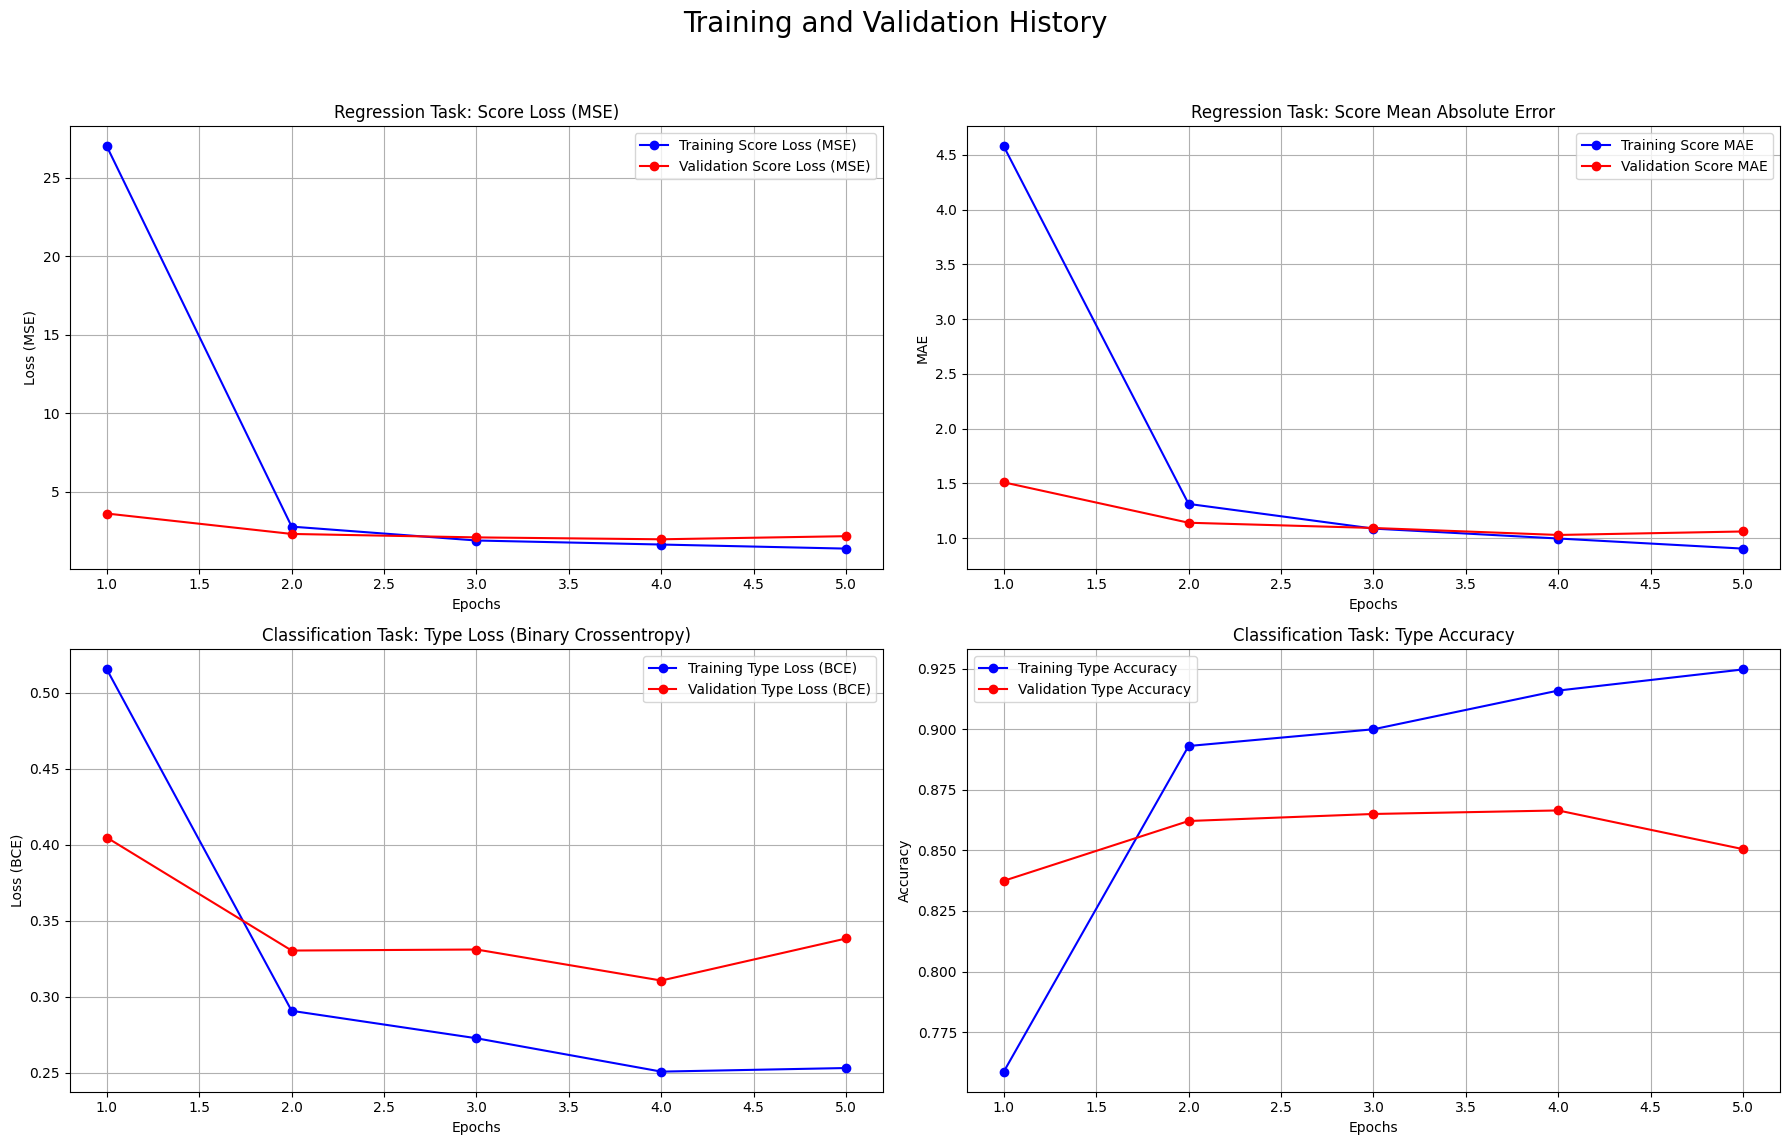

In [200]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    
    score_loss = 'review_score_loss'
    val_score_loss = 'val_review_score_loss'
    score_mae = 'review_score_mae'
    val_score_mae = 'val_review_score_mae'

    type_loss = 'review_type_loss'
    val_type_loss = 'val_review_type_loss'
    type_acc = 'review_type_accuracy'
    val_type_acc = 'val_review_type_accuracy'

    epochs = range(1, len(history.history[score_loss]) + 1)

    fig, axs = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Training and Validation History', fontsize=20)

    axs[0, 0].plot(epochs, history.history[score_loss], 'bo-', label='Training Score Loss (MSE)')
    axs[0, 0].plot(epochs, history.history[val_score_loss], 'ro-', label='Validation Score Loss (MSE)')
    axs[0, 0].set_title('Regression Task: Score Loss (MSE)')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss (MSE)')
    axs[0, 0].legend()
    axs[0, 0].grid(True)
    
    axs[0, 1].plot(epochs, history.history[score_mae], 'bo-', label='Training Score MAE')
    axs[0, 1].plot(epochs, history.history[val_score_mae], 'ro-', label='Validation Score MAE')
    axs[0, 1].set_title('Regression Task: Score Mean Absolute Error')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('MAE')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    axs[1, 0].plot(epochs, history.history[type_loss], 'bo-', label='Training Type Loss (BCE)')
    axs[1, 0].plot(epochs, history.history[val_type_loss], 'ro-', label='Validation Type Loss (BCE)')
    axs[1, 0].set_title('Classification Task: Type Loss (Binary Crossentropy)')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Loss (BCE)')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    axs[1, 1].plot(epochs, history.history[type_acc], 'bo-', label='Training Type Accuracy')
    axs[1, 1].plot(epochs, history.history[val_type_acc], 'ro-', label='Validation Type Accuracy')
    axs[1, 1].set_title('Classification Task: Type Accuracy')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Accuracy')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_training_history(history)

The graphs show that the model converges quickly but begins to show clear overfitting after the first few epochs.
Regression Task: The validation metrics (MSE and MAE, in red) stabilize after epoch 2, while the training metrics continue to improve, indicating that the model is memorizing the training data.
Classification Task: Validation accuracy (bottom right) peaks at epoch 4 and then declines, a classic sign that the model has exceeded its optimal point of generalization.



---



# 6 - MODEL EVALUATION

This section is dedicated to the final evaluation of the best-performing model, identified through the hyperparameter optimization process. As stated in the exam, the evaluation addresses the model's multi-task nature by assessing its performance on both the **regression task** (predicting the `Review Score`) and the **classification task** (predicting the `Review Type`).

The evaluation is conducted on the **unseen test set** to provide an unbiased estimate of the model's generalization capabilities. The process follows the plan outlined in the exam:
1.  Evaluate each task separately using appropriate metrics (MSE for regression, Accuracy/F1 for classification).
2.  Visualize the results to gain deeper insights (e.g., Confusion Matrix and performance plots).
3.  Calculate the custom **merged evaluation score** to provide a single, complete measure of performance, as proposed in my exam.

In [201]:
test_pred_score, test_pred_type = best_model.predict(
    {'text_input': test_seqs,
     'hotel_input': test_hot,
     'numeric_input': test_nums},
    verbose=0
)

### 6.1. Clipping 
As said during the exam, as a post-processing step, i'm going to clip the regression outputs to the valid score range [2.5, 10.0], This ensures that the model does not produce physically impossible scores

In [202]:
min_score, max_score = 2.5, 10.0
test_pred_score_clipped = np.clip(test_pred_score.flatten(), min_score, max_score)
test_pred_label = (test_pred_type.flatten() >= 0.5).astype(int)

### 6.2 Performance Visualization
To immediately see the model's combined performance, the following scatterplot visualizes the relationship between the true and predicted scores, while also showing the true class of each review. This plot provides a rich, multi-faceted view of the model's behavior. An ideal model would place all points along the dashed "Perfect Prediction" line.The color coding reveals how prediction errors are distributed across the two classes.


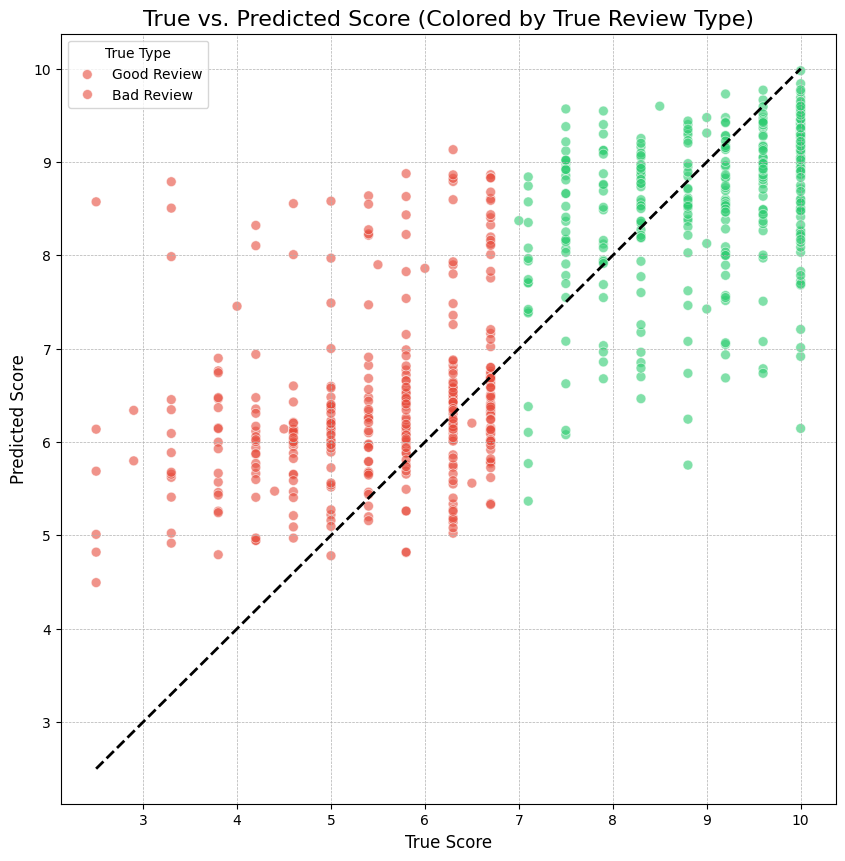

In [ ]:
legend_labels = {0: 'Bad Review', 1: 'Good Review'}
plt.figure(figsize=(10, 10))
sns.scatterplot(x=test_df['Review_Score'], y=test_pred_score_clipped, hue=test_df['Review_Type'],
                palette=['#E74C3C', '#2ECC71'], alpha=0.6, s=50)
plt.plot([min_score, max_score], [min_score, max_score], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel('True Score', fontsize=12)
plt.ylabel('Predicted Score', fontsize=12)
plt.title('True vs. Predicted Score (Colored by True Review Type)', fontsize=16)
plt.legend(title='True Type', labels=[legend_labels[i] for i in sorted(test_df['Review_Type'].unique())])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

### Analysis of the Performance Plot

The scatterplot provides a crucial insight into the model's behavior within its multi-task learning framework. A detailed analysis reveals an intresting dynamic:

1.  **Excellent Classification Performance:** The model demonstrates a remarkable ability to distinguish between "Good Reviews" and "Bad Reviews", as shown by the clear separation of colors. This indicates that the classification head of the model has learned very strong patterns from the data.

2.  **Regression:** For the regression task, the model appears to have adopted a heuristic-based approach rather than a fine-grained prediction model. It has correctly identified the strong correlation between the review type and the score range. Consequently:
    *   When a review is classified as "Bad," the model predicts a score within a general "low-to-medium" range.
    *   When a review is classified as "Good," it predicts a score within a "high" range.

**Why this happens?**

I think that the classification task, likely being "easier" or having a steeper loss gradient, has dominated the training process. By mastering the classification, the model already achieves a reasonably low Mean Squared Error, thus reducing the learning incentive to further refine the exact score prediction.

**Addressing the Imbalance**
To validate this hypothesis, I experimented by significantly increasing the weight of the regression loss (`loss_weight_score`) during training. This forces the model to prioritize the reduction of the MSE. This effectively led to some improvements. 

### 6.3 Task-Specific Quantitative Evaluation
Following the visual analysis, we now compute the specific metrics for each task as planned in the exam.


Regression Task
Mean Squared Error on Test Set: 1.7814
Accuracy within +/- 1.5 score points: 77.21%

Classification Task
Accuracy on Test Set: 0.8911
F1 Score on Test Set: 0.8948


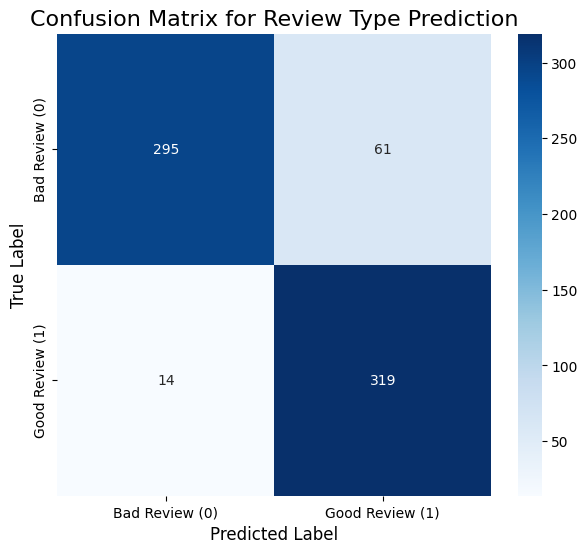

In [ ]:
print("\nRegression Task")
test_mse = mean_squared_error(test_df['Review_Score'], test_pred_score_clipped)
print(f"Mean Squared Error on Test Set: {test_mse:.4f}")

def evaluate_score_on_scale(true_scores, predicted_scores, tolerance=1.5):
    correct_within_tolerance = np.sum(np.abs(true_scores - predicted_scores) <= tolerance)
    accuracy_within_tolerance = correct_within_tolerance / len(true_scores)
    print(f"Accuracy within +/- {tolerance} score points: {accuracy_within_tolerance:.2%}")

evaluate_score_on_scale(test_df['Review_Score'].values, test_pred_score_clipped)

print("\nClassification Task")
test_accuracy = accuracy_score(test_df['Review_Type'], test_pred_label)
test_f1 = f1_score(test_df['Review_Type'], test_pred_label)

print(f"Accuracy on Test Set: {test_accuracy:.4f}")
print(f"F1 Score on Test Set: {test_f1:.4f}")

cm = confusion_matrix(test_df['Review_Type'], test_pred_label)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bad Review (0)', 'Good Review (1)'],
            yticklabels=['Bad Review (0)', 'Good Review (1)'])
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix for Review Type Prediction', fontsize=16)
plt.show()

### 6.4 Merged Evaluation Score
Finally, as proposed in the exam, I compute the single merged score that combines the performance on both tasks. This metric, already used during hyperparameter tuning, provides a unified view of the model's overall quality.

In [205]:
merged_test_score = np.sqrt(test_accuracy * test_f1 * (1.0 / (np.log(test_mse + 1) + 1)))
print(f"Final Merged Evaluation Score on Test Set: {merged_test_score:.4f}")

Final Merged Evaluation Score on Test Set: 0.6278
